# Demo - SNR evolution over time
This demo uses ``LEGWORK`` to show how we could track the SNR of a source if we observed it at different times

In [1]:
%matplotlib inline

In [2]:
import legwork as lw
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': 0.7 * fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

To start we can define the initial parameters of the source and work out how long it will take until it will merge.

**Feel free to change these values to see how the plot changes!!**

In [4]:
m_1 = 15 * u.Msun
m_2 = 15 * u.Msun
dist = 20 * u.kpc
ecc = 0.5
f_orb = 3e-5 * u.Hz

In [5]:
t_merge = lw.evol.get_t_merge_ecc(m_1=m_1, m_2=m_2, ecc_i=ecc, f_orb_i=f_orb)

Next we can evolve the system up until a year before it merges with 1000 timesteps and record the eccentricity and frequency evolution as well as the timesteps.

In [6]:
ecc_evol, f_orb_evol, timesteps = lw.evol.evol_ecc(m_1=m_1,
                                                   m_2=m_2,
                                                   ecc_i=ecc,
                                                   f_orb_i=f_orb,
                                                   t_evol=t_merge - 100 * u.yr,
                                                   avoid_merger=False,
                                                   output_vars=["ecc", "f_orb", "timesteps"],
                                                   n_step=1000)

We then take these evolved values and treat them as different sources that occur at different times and calculate the SNR for each one.

In [7]:
source = lw.source.Source(m_1=np.repeat(m_1, len(ecc_evol)),
                          m_2=np.repeat(m_2, len(ecc_evol)),
                          dist=np.repeat(dist, len(ecc_evol)),
                          ecc=ecc_evol,
                          f_orb=f_orb_evol)

snr = source.get_snr()

Now we can plot the results! Let's compare how the eccentricity, frequency and SNR change as we approach the merger.

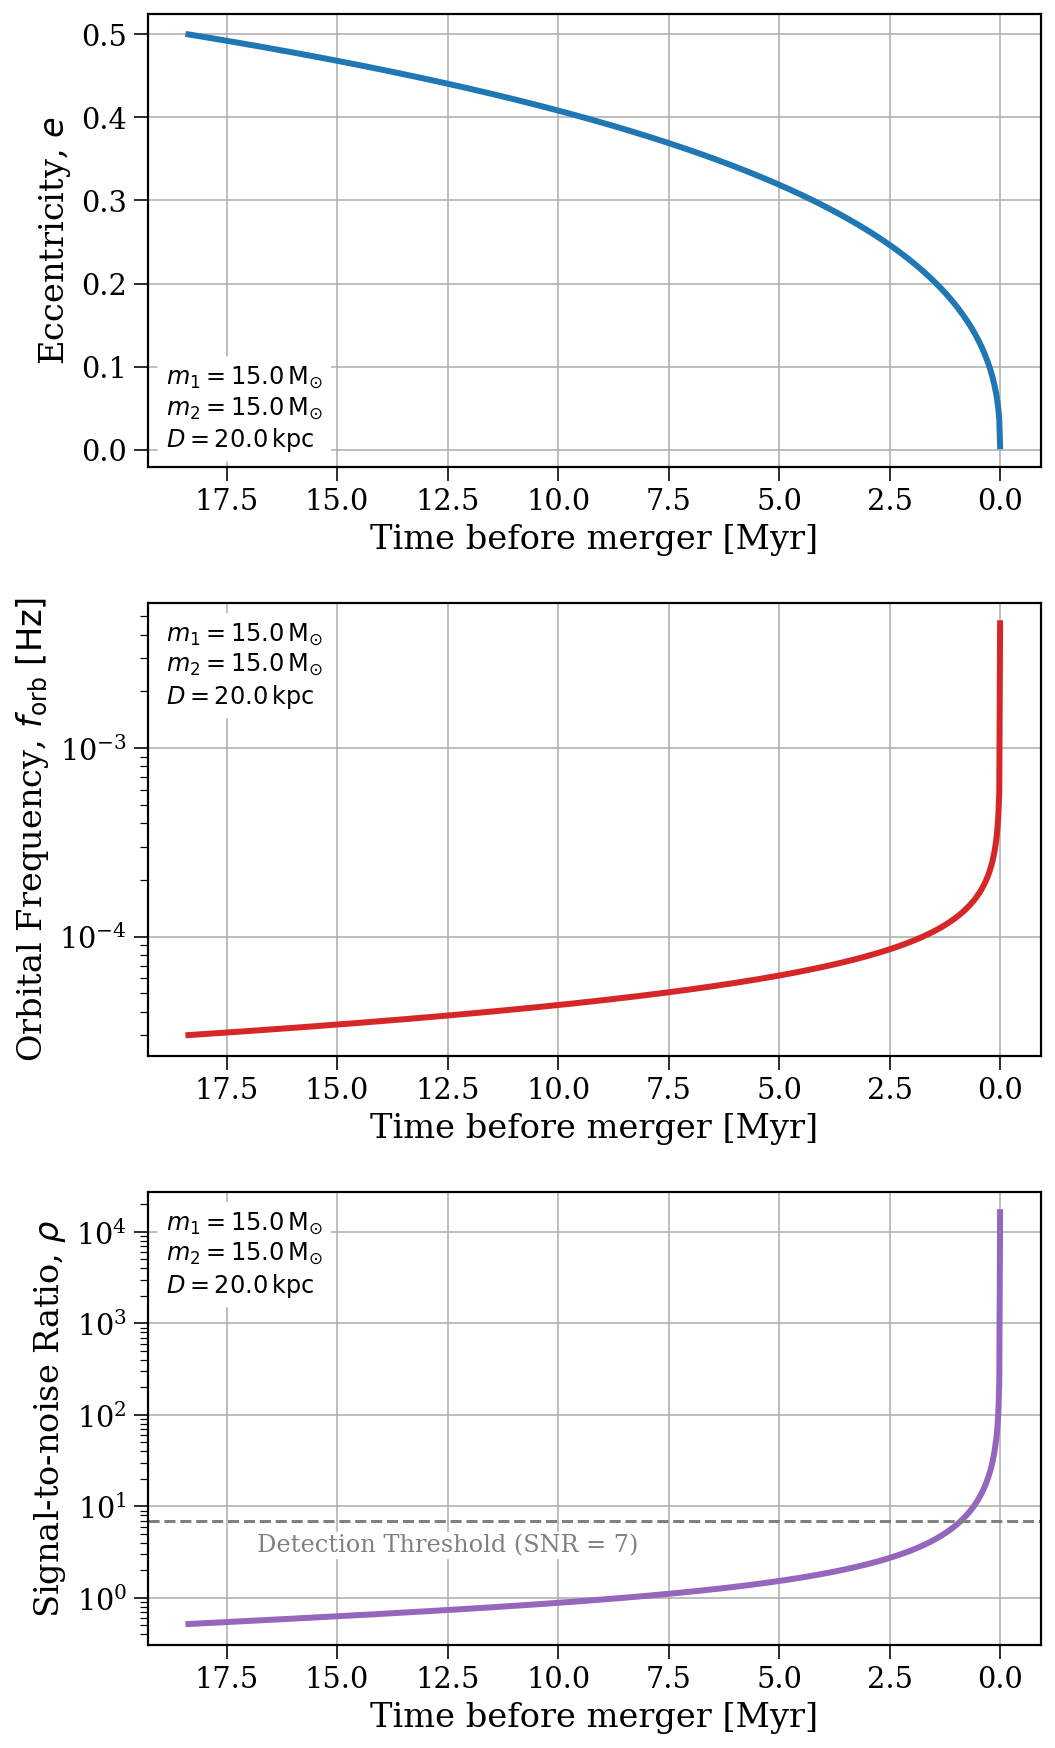

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(8, 15))
fig.subplots_adjust(hspace=0.3)

# calculate the time before the merger rather than timesteps
t_before_merger = (t_merge - timesteps).to(u.Myr)

# plot the eccentricity
axes[0].plot(t_before_merger, source.ecc, lw=3)
axes[0].set_ylabel(r"Eccentricity, $e$")

# plot the frequency on a log scale
axes[1].plot(t_before_merger, source.f_orb, lw=3, color="tab:red")
axes[1].set_yscale("log")
axes[1].set_ylabel(r"Orbital Frequency, $f_{\rm orb}\ [\rm Hz]$")

# plot the SNR on a log scale
axes[2].plot(t_before_merger, source.snr, lw=3, color="tab:purple")
axes[2].set_yscale("log")
axes[2].set_ylabel(r"Signal-to-noise Ratio, $\rho$")

# add a line to indicate the detection threshold
axes[2].axhline(7, color="grey", linestyle="--")
axes[2].annotate("Detection Threshold (SNR = 7)", xy=(12.5, 5), ha="center", va="top", fontsize=0.5*fs, color="grey",
                 bbox=dict(boxstyle="round", fc="white", ec="white", pad=0.05))


params_string = r"$m_1 = {{{}}}\,${:latex}".format(m_1.value, m_1.unit)
params_string += "\n" + r"$m_2 = {{{}}}\,${:latex}".format(m_2.value, m_2.unit)
params_string += "\n" + r"$D = {{{}}}\,${:latex}".format(dist.value, dist.unit)

for ax in axes:
    ax.set_xlim(reversed(ax.get_xlim()))
    ax.grid()
    ax.set_xlabel("Time before merger [Myr]")
    ax.annotate(params_string, xy=(0.02, 0.96 if ax != axes[0] else 0.03),
                xycoords="axes fraction", va="top" if ax != axes[0] else "bottom",
                fontsize=0.5*fs, bbox=dict(boxstyle="round", fc="white", ec="white"))

plt.show()